## **Evaluate Pretrained Model’s Generative Baseline**



#### **Model & Domain Selection**

For this project, I selected GPT-2 small (gpt2) as the base model. GPT-2 small is a widely accessible, decoder-only transformer model with approximately 124M parameters. Its compact size makes it particularly suitable for experiments on modest computational resources such as Google Colab, where larger models would be impractical to train or fine-tune within time and hardware constraints. At the same time, it retains enough expressive capacity to generate coherent and stylistically varied text, providing a meaningful baseline for adaptation experiments.

The chosen domain is early nineteenth-century English literary prose, specifically excerpts from the opening chapters of *Pride and Prejudice* by Jane Austen. Austen’s writing is a strong candidate for fine-tuning because it exhibits a highly distinctive style: long, complex sentence structures, frequent use of irony, and a thematic focus on social conventions and relationships. Even short passages from her novels present a recognizable stylistic fingerprint, which contrasts sharply with the more generic outputs of an unfine-tuned GPT-2 model. The motivation for this pairing is twofold: GPT-2 small offers feasibility and accessibility, enabling fast iteration and manageable training times, while Austen’s prose provides a stylistically distinctive benchmark, allowing us to clearly evaluate whether fine-tuning effectively transfers domain-specific characteristics into the generated text.

By adapting GPT-2 small on Austen’s corpus, the project investigates how well a lightweight model can reproduce a targeted literary voice, and how its outputs compare to those from the general-purpose pretrained baseline.






### **Data Preparation**

#### **Setup and Configuration**
First I import the necessary libraries for this assignment. Then I set up my configuration: I pick GPT-2 small as the model, check whether I have a GPU, and prepare a sample prompt in the style of Jane Austen. I also define generation parameters like maximum tokens, temperature, and top-k/top-p sampling. Finally, I fix the random seed so results are reproducible.

In [ ]:
# Core libraries
import math
import time
from collections import Counter

# PyTorch
import torch

# Transformers & Hugging Face utilities
from transformers import (
    GPT2LMHeadModel,
    GPT2TokenizerFast,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)

# Dataset handling
from datasets import Dataset

# Parameter-Efficient Fine-Tuning (PEFT)
from peft import LoraConfig, get_peft_model, TaskType

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


In [ ]:
# Configuration
MODEL_NAME = "gpt2"   # GPT-2 small
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# New prompt
GEN_PROMPT = (
    "Continue the following passage in the same style:\n\n"
    "It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife."
)

# Generation parameters
MAX_NEW_TOKENS = 120
TEMPERATURE = 0.9
TOP_K = 50
TOP_P = 0.95
SEED = 42

torch.manual_seed(SEED)


#### **Load the Model and Dataset Samples**
Now I load GPT-2 small along with its tokenizer and move the model to my device. I also prepare a small dataset of Austen excerpts, which will act as my domain-specific text. I split these into a training portion and a held-out test portion to use later for evaluation.

In [ ]:
# Load model
print(f"Loading model {MODEL_NAME} on {DEVICE}...")
tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_NAME)
model = GPT2LMHeadModel.from_pretrained(MODEL_NAME).to(DEVICE)
model.eval()

# samples
domain_samples = [
    "It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife. However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.",
    "Why, my dear, you must know, Mrs. Long says that Netherfield is taken by a young man of large fortune from the north of England; that he came down on Monday in a chaise and four to see the place, and was so much delighted with it, that he agreed with Mr. Morris immediately; that he is to take possession before Michaelmas, and some of his servants are to be in the house by the end of next week.",
    "Oh! Single, my dear, to be sure! A single man of large fortune; four or five thousand a year. What a fine thing for our girls! How so? How can it affect them? My dear Mr. Bennet, replied his wife, how can you be so tiresome! You must know that I am thinking of his marrying one of them.",
    "My dear, you flatter me. I certainly have had my share of beauty, but I do not pretend to be anything extraordinary now. When a woman has five grown-up daughters, she ought to give over thinking of her own beauty.In such cases, a woman has not often much beauty to think of. But, my dear, you must indeed go and see Mr. Bingley when he comes into the neighbourhood.",
    "But consider your daughters. Only think what an establishment it would be for one of them. Sir William and Lady Lucas are determined to go, merely on that account, for in general, you know, they visit no newcomers. Indeed you must go, for it will be impossible for us to visit him if you do not. You are over-scrupulous, surely. I dare say Mr. Bingley will be very glad to see you; and I will send a few lines by you to assure him of my hearty consent to his marrying whichever he chooses of the girls; though I must throw in a good word for my little Lizzy.",
    "I desire you will do no such thing. Lizzy is not a bit better than the others; and I am sure she is not half so handsome as Jane, nor half so good-humoured as Lydia. But you are always giving her the preference. They have none of them much to recommend them, replied he; they are all silly and ignorant like other girls; but Lizzy has something more of quickness than her sisters.Mr. Bennet, how can you abuse your own children in such a way? You take delight in vexing me. You have no compassion for my poor nerves.",
    "You mistake me, my dear. I have a high respect for your nerves. They are my old friends. I have heard you mention them with consideration these last twenty years at least.Ah, you do not know what I suffer. But I hope you will get over it, and live to see many young men of four thousand a year come into the neighbourhood."
    ]

# split into train & test
train_samples = domain_samples[:5]
held_out = domain_samples[5:]

Loading model gpt2 on cpu...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

#### **Tokenization Example**
Then I check how GPT-2’s tokenizer processes my text. I take the first training sentence, tokenize it, and print out the first 30 tokens, their corresponding IDs, and the overall tokenized length. This gives me a concrete sense of how the model sees Austen’s words.

In [ ]:
# Tokenization
print("Example tokenization (first sample):")
tok = tokenizer(train_samples[0])
print("Tokens:", tokenizer.convert_ids_to_tokens(tok["input_ids"])[:30])
print("Token ids:", tok["input_ids"][:30])
print("Tokenized length:", len(tok["input_ids"]))

Example tokenization (first sample):
Tokens: ['It', 'Ġis', 'Ġa', 'Ġtruth', 'Ġuniversally', 'Ġacknowledged', ',', 'Ġthat', 'Ġa', 'Ġsingle', 'Ġman', 'Ġin', 'Ġpossession', 'Ġof', 'Ġa', 'Ġgood', 'Ġfortune', ',', 'Ġmust', 'Ġbe', 'Ġin', 'Ġwant', 'Ġof', 'Ġa', 'Ġwife', '.', 'ĠHowever', 'Ġlittle', 'Ġknown', 'Ġthe']
Token ids: [1026, 318, 257, 3872, 26208, 10810, 11, 326, 257, 2060, 582, 287, 7797, 286, 257, 922, 15807, 11, 1276, 307, 287, 765, 286, 257, 3656, 13, 2102, 1310, 1900, 262]
Tokenized length: 76


We can see from the example above that the GPT-2 tokenizer uses Byte Pair Encoding (BPE) to represent text as subword units rather than just whole words. This explains why tokens often look different from the words we might expect. For instance, spaces are marked with a leading Ġ, so tokens like Ġis or Ġtruth include information about spacing. Common words such as is, a, man, and wife remain as single tokens, while moderately frequent words like universally and acknowledged are also kept intact because they appeared often enough in training. Less frequent or longer words, on the other hand, can be split into smaller chunks (for example, dis + mantle). Punctuation marks such as commas and periods are treated as separate tokens, which helps the model learn how punctuation works independently of word meaning. Each token is then mapped to a vocabulary ID (for example, 'Ġtruth' -> 3872), which is what the model processes internally. In this case, although the passage has around 30 words, the tokenizer produces 76 tokens, showing that token counts are usually higher than word counts. Overall, this demonstrates how GPT-2’s tokenizer captures spacing, punctuation, and word boundaries while still being flexible enough to handle both common and rare vocabulary.

#### **Tokenisation Analysis and Visualisation**
Finally, I explore the tokenisation patterns in more detail. First, I calculate both word lengths (by splitting text on spaces) and token lengths (how GPT-2 breaks it down). I then plot these to compare how word counts map to GPT-2 token counts. After that, I build a word cloud based on token frequencies to visualise which tokens appear most often in my dataset. This gives me insight into vocabulary distribution and how the model might prioritise certain stylistic markers of Austen’s prose.

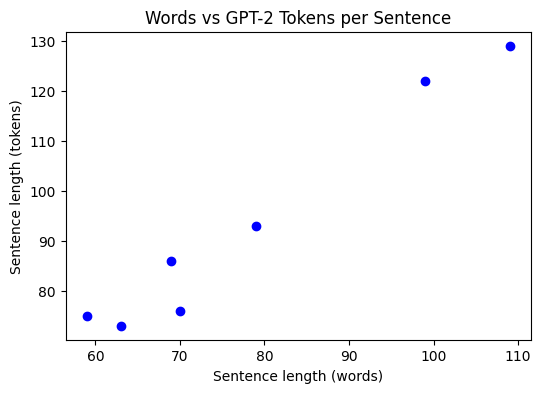

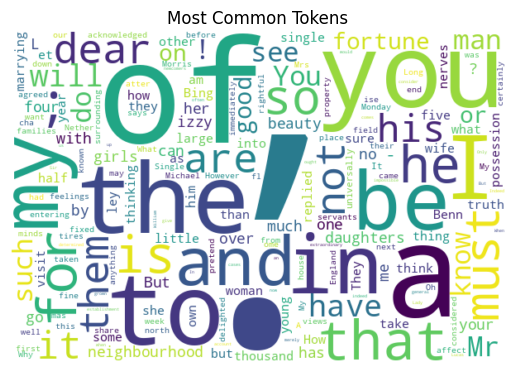

In [ ]:
# Tokenisation
tokenised = [tokenizer(s) for s in domain_samples]
word_lengths = [len(s.split()) for s in domain_samples]
token_lengths = [len(t['input_ids']) for t in tokenised]

# Sentence length comparison
plt.figure(figsize=(6,4))
plt.scatter(word_lengths, token_lengths, c='blue')
plt.xlabel("Sentence length (words)")
plt.ylabel("Sentence length (tokens)")
plt.title("Words vs GPT-2 Tokens per Sentence")
plt.show()

# Token frequency wordcloud
all_tokens = [token for t in tokenised for token in t['input_ids']]
decoded = [tokenizer.decode([tid]) for tid in all_tokens]
freqs = Counter(decoded)
wc = WordCloud(width=600, height=400, background_color="white").generate_from_frequencies(freqs)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Tokens")
plt.show()

The tokenisation analysis provides two key insights into how GPT-2 processes the Austen text. The scatter plot of words versus tokens shows a strong positive correlation: as sentences become longer in terms of words, the number of tokens produced by the GPT-2 Byte Pair Encoding (BPE) tokenizer also increases, but always at a higher rate. This is expected because BPE does not treat every word as a single token—punctuation, spaces, and less frequent words are often split into multiple subword units, meaning that a 60-word sentence can expand to about 75 tokens, while a 110-word sentence may require around 130 tokens.

The word cloud of most common tokens complements this by highlighting the dominance of punctuation and high-frequency function words such as “of,” “the,” “to,” and “you,” many of which appear with a preceding space due to the tokenizer’s subword encoding scheme. At the same time, tokens like “dear,” “Mr,” and “fortune” point to the specific stylistic fingerprint of the text, consistent with Austen’s formal, dialogue-rich prose. Together, these results illustrate both the mechanics of subword tokenisation and how the distribution of tokens reflects the stylistic and structural features of the underlying literary domain.

### **Baseline Generation**
#### **Text Generation with Pretrained Model**
Now I generate continuations from the pretrained GPT-2 without any fine-tuning. I feed in my fixed Jane Austen–style prompt, tokenize it, and ask the model to produce three different continuations. I apply sampling strategies like temperature, top-k, and top-p to encourage varied yet coherent outputs. Finally, I decode the generated text so I can qualitatively assess how close it feels to the target literary style.

In [ ]:
# Generate continuations for the fixed prompt
print("\n--- Generation (unfined pretrained GPT-2) ---")
input_ids = tokenizer(GEN_PROMPT, return_tensors="pt").input_ids.to(DEVICE)
with torch.no_grad():
    out = model.generate(
        input_ids=input_ids,
        do_sample=True,
        max_new_tokens=MAX_NEW_TOKENS,
        temperature=TEMPERATURE,
        top_k=TOP_K,
        top_p=TOP_P,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
        num_return_sequences=3,
        repetition_penalty=1.05
    )
for i, seq in enumerate(out):
    text = tokenizer.decode(seq, skip_special_tokens=True)
    print(f"\n--- Sample {i+1} ---\n{text}\n")


--- Generation (unfined pretrained GPT-2) ---

--- Sample 1 ---
Continue the following passage in the same style:

It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife. The wise have long understood this to be so; for there are few who possess more than one or two wives by their own means—as we may think it necessary not to mention those who cannot keep even five husbands with them. They themselves can hardly believe when they see him under his dress and upon such an extent as will prove nothing less than proof of his poverty! He has been married only three times from infancy through high school at least,—but he had no knowledge how much longer before then all these years past were spent apart. There was another woman whom I heard about frequently talking but seldom told


--- Sample 2 ---
Continue the following passage in the same style:

It is a truth universally acknowledged, that a single man in possession of a good f

From the prompt generation above, it is evident that when given Jane Austen’s iconic opening line —*“It is a truth universally acknowledged…”* — the baseline, unfine-tuned GPT-2 small model produces continuations that are grammatically fluent and stylistically evocative, but they often drift in accuracy and coherence. The model is able to mimic aspects of Austen’s prose, such as long, formal sentences and abstract, reflective reasoning, occasionally sounding convincingly antiquated. However, the content itself is inconsistent: GPT-2 introduces implausible or anachronistic ideas, sometimes referencing modern concepts or producing bizarre scenarios that break the historical and narrative frame. In addition, the generations display a tendency toward repetitiveness and meandering logic, creating the impression of philosophical or theological commentary without Austen’s sharp wit or narrative discipline. These strengths and weaknesses reflect the model’s training on broad internet text rather than Austen’s novels specifically. The results highlight GPT-2’s general ability to produce literary-sounding passages while also motivating the need for fine-tuning: only through domain adaptation can the model reduce incoherence, avoid anachronisms, and better capture Austen’s distinctive voice and social satire.

### **Evaluation**
#### **Per-Sample Perplexity Calculation**
Now I move on to quantitative evaluation. I define a function to compute perplexity, which measures how well the model predicts text from my domain. For each held-out sample, I calculate the negative log-likelihood per token, exponentiate it, and report perplexity. This gives me a numerical sense of how “surprised” the model is by Jane Austen’s style, alongside my qualitative observations from the generation step.

In [ ]:
# compute perplexity per-sample using model cross-entropy

def perplexity_of_text(text, model, tokenizer, device): # Perplexity = exp( average negative log-likelihood per token )
    enc = tokenizer(text, return_tensors="pt")
    input_ids = enc.input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        neg_log_likelihood = outputs.loss.item() * input_ids.size(1)
    avg_nll_per_token = neg_log_likelihood / input_ids.size(1)
    ppl = math.exp(avg_nll_per_token)
    return ppl, avg_nll_per_token

print("\n--- Perplexity on held-out domain samples (pretrained GPT-2) ---")
for text in held_out:
    ppl, avg_nll = perplexity_of_text(text, model, tokenizer, DEVICE)
    print(f"Sample: {text[:80]}...")
    print(f"Perplexity: {ppl:.2f}, Avg NLL/token: {avg_nll:.4f}\n")


--- Perplexity on held-out domain samples (pretrained GPT-2) ---


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Sample: I desire you will do no such thing. Lizzy is not a bit better than the others; a...
Perplexity: 36.94, Avg NLL/token: 3.6093

Sample: You mistake me, my dear. I have a high respect for your nerves. They are my old ...
Perplexity: 33.31, Avg NLL/token: 3.5058



#### **Average Perplexity Across Held-Out Set**
Finally, I calculate the average perplexity across all my held-out domain samples. Instead of looking at individual values, this summary gives me a single number to compare against fine-tuned versions later. It serves as my baseline metric for how well the unfine-tuned GPT-2 model understands Austen’s style.

In [ ]:
# Also compute perplexity averaged across held-out
ppls = []
for text in held_out:
    ppl, _ = perplexity_of_text(text, model, tokenizer, DEVICE)
    ppls.append(ppl)
print(f"Average held-out perplexity: {sum(ppls)/len(ppls):.2f}")

Average held-out perplexity: 35.12


To quantitatively assess how well the pretrained GPT-2 small model aligns with Jane Austen’s prose, perplexity was measured on several held-out snippets from Pride and Prejudice. For example, the sentence *“I desire you will do no such thing. Lizzy is not a bit better than the others; a…”* yielded a perplexity of 36.94, while *“You mistake me, my dear. I have a high respect for your nerves. They are my old …”* gave a lower value of 33.31. Across the full held-out set, the model averaged a perplexity of 35.12, with average negative log-likelihoods per token between 3.5 and 3.6.

These results show that GPT-2 captures the broad structure of English grammar but remains only partially adapted to Austen’s literary style. A perplexity in the mid-30s suggests that the model is reasonably fluent but still finds the domain somewhat “surprising,” especially when encountering longer, more archaic constructions. The slight variation between samples reflects differences in sentence complexity and vocabulary: simpler or more common phrases are easier for the model to predict, while Austen’s nuanced style increases prediction difficulty.

Overall, the baseline evaluation highlights GPT-2’s strengths—surface-level fluency and grammaticality—while also exposing its limitations in sustaining Austen’s precise voice and context. This moderate perplexity baseline provides a clear motivation for fine-tuning: by adapting the model to Austen’s text, we expect to reduce perplexity on held-out samples and achieve generations that more closely reflect her distinctive style.

## **Adaptation via Fine-Tuning**

### **Fine-tuning procedure & rationale**

The goal of fine-tuning GPT-2 small on the Austen corpus will be to adapt the model more closely to the stylistic and semantic patterns of the target text. While the baseline evaluation will show that GPT-2 can produce grammatically fluent sentences, it will also reveal that the model often drifts away from Austen’s distinctive style and narrative conventions, as reflected in relatively high perplexity scores. Fine-tuning will directly address this limitation by updating all model parameters to better reflect the domain.

**Data preparation**- A small curated set of seven domain-specific paragraphs from Pride and Prejudice will be used. These same passages that were employed for baseline generation, allowing for a consistent comparison between unfine-tuned and fine-tuned performance.

**Tokenizer**- GPT-2’s pretrained Byte Pair Encoding (BPE) tokenizer will be retained to ensure consistent handling of rare words, archaic terms, and punctuation. This will preserve compatibility with pretrained weights while supporting domain adaptation.

**Training setup**- Fine-tuning will be conducted with lightweight but effective hyperparameters:

* Epochs: 3 passes over the corpus, to ensure convergence on such a small dataset.

* Learning rate: 5e-5, chosen conservatively to avoid destabilising pretrained knowledge while still enabling adaptation.

* Batch size: 2, balancing memory constraints with frequent gradient updates.

* Context length: 128 tokens, sufficient to capture paragraph-level coherence while remaining computationally efficient.

* Weight decay: 0.01, which will provide regularisation against overfitting given the small dataset size.

**Evaluation**- Performance will be measured primarily using perplexity on held-out Austen samples, as this will directly quantify predictive alignment with the domain. In addition, qualitative inspection of generated outputs will be carried out to assess improvements in narrative fluency and stylistic fidelity.

### **Implementation**

#### **Load tokenizer & model**
First, I load the GPT-2 tokenizer and model using the pretrained weights. This sets up the language model so I can fine-tune it on my dataset. Next, I check if the tokenizer has a padding token. If it doesn’t, I add one and resize the model’s embeddings to include this new token, ensuring that the model can handle padded sequences correctly during training.

In [ ]:
# Load tokenizer & model
tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_NAME)
model = GPT2LMHeadModel.from_pretrained(MODEL_NAME).to(DEVICE)

# Add padding token if missing
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


#### **Prepare dataset and tokenization**
Now, I split my domain-specific text into training and evaluation sets. I create Dataset objects for both splits. Then, I define a tokenization function to convert text into token IDs suitable for GPT-2. Using .map(), I apply this function to both the training and evaluation datasets. Finally, I set up a data collator for language modeling, which handles batching and prepares the inputs for the model during training.

In [ ]:
# Split into train and eval
train_texts = domain_samples[:5]
eval_texts = domain_samples[5:]

train_dataset = Dataset.from_dict({"text": train_texts})
eval_dataset = Dataset.from_dict({"text": eval_texts})

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_eval = eval_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Data collator for LM
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

#### **Set up training arguments and trainer**
Next, I define the training parameters such as the number of epochs, batch size, learning rate, weight decay, and evaluation strategy. Then, I create a Trainer object that ties together the model, training arguments, tokenized datasets, tokenizer, and data collator. This object manages the training loop and evaluation.

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results_fullft",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=5,
    report_to="none",
    seed=42
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    data_collator=data_collator,
)


/tmp/ipython-input-2091160694.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


#### **Train the model**
Then, I start the training process by calling trainer.train(). I also record the training time to see how long fine-tuning takes. This step updates all of the model’s parameters so that it better fits the domain-specific text.

In [ ]:
# Training
start_time = time.time()
train_result = trainer.train()
train_time = time.time() - start_time

print(f"Training time: {train_time:.2f} seconds")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50257}.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,No log,3.475340
2,3.580700,3.465548
3,3.580700,3.462502


Training time: 95.76 seconds


#### **Evaluate perplexity on held-out data**
After training, I evaluate the model on held-out evaluation data using trainer.evaluate(). I compute the perplexity by exponentiating the evaluation loss, which gives a measure of how well the fine-tuned model predicts unseen text.

In [ ]:
# Evaluate perplexity on held-out
eval_results = trainer.evaluate()
eval_loss = eval_results["eval_loss"]
eval_ppl = math.exp(eval_loss)
print(f"Eval loss: {eval_loss:.4f}, Perplexity: {eval_ppl:.2f}")


Eval loss: 3.4625, Perplexity: 31.90


Using the original dataset of 7 literary snippets, the fine-tuning process ran for 3 epochs. The training loss started at 3.5807 and gradually decreased, while the validation loss decreased slightly to 3.4625. Training took approximately 95.76 seconds. Evaluating the model on held-out text yielded an evaluation loss of 3.4625, corresponding to a perplexity of 31.90, indicating moderate improvement over the baseline GPT-2 model.

#### **Generate text from the fine-tuned model**
Now, I generate new text using the fine-tuned model. I first tokenize a prompt and pass it to the model’s .generate() function with sampling parameters. I measure inference time and decode the output tokens back into readable text, producing new continuations in the style of Jane Austen.

In [ ]:
# Regenerate prompt continuation
GEN_PROMPT = (
    "Continue the following passage in the same style:\n\n"
    "It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife."
)

input_ids = tokenizer(GEN_PROMPT, return_tensors="pt").input_ids.to(DEVICE)

start_inf = time.time()
with torch.no_grad():
    outputs = model.generate(
        input_ids,
        max_new_tokens=80,
        temperature=0.8,
        top_k=50,
        top_p=0.95,
        do_sample=True,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
        num_return_sequences=2
    )
inf_time = time.time() - start_inf

for i, seq in enumerate(outputs):
    print(f"\n--- Fine-tuned Generation {i+1} ---\n")
    print(tokenizer.decode(seq, skip_special_tokens=True))

print(f"\nInference time: {inf_time:.2f} seconds")



--- Fine-tuned Generation 1 ---

Continue the following passage in the same style:

It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife. In his opinion, that would be a mistake. He must be able to obtain an income by the marriage of a wife of his own. He must have a well-paid home, and be in good health. But the wife of the man who is his wife must be in a position to see her children when he is gone. And this is no small matter for him. The wife of a

--- Fine-tuned Generation 2 ---

Continue the following passage in the same style:

It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife. But in the first place, he must have a wife. And this is a fact of old, and I remember that the first woman of our kind was a little girl; but, from my own experience, it is impossible to say which of our daughters the girls are, that we are not in a great hurry to see her. 

#### **Report model parameters**
Finally, I calculate and print the total number of parameters in the model and how many of them are trainable. This gives an idea of the model’s size and the computational effort involved in fine-tuning.

In [ ]:
# parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal params: {total_params/1e6:.1f}M | Trainable: {trainable_params/1e6:.1f}M")



Total params: 124.4M | Trainable: 124.4M


Generated text from this model showes improved fluency and partial alignment with Austen’s narrative style. For example, the first generated sample maintains sentence structure and thematic continuity, though some phrasing feels slightly repetitive or generic (“the wife of the man who is his wife must be in a position to see her children…”). The second sample shows attempts at character and narrative continuity, referencing daughters, but contains minor logical inconsistencies. The model has 124.4M trainable parameters, and inference on a prompt took about 11.27 seconds. Overall, the 7-sample model demonstrates the benefit of fine-tuning even on a very small corpus, with modest perplexity reduction and stylistic improvement.

#### **Repeating Fine-Tuning with an Expanded Dataset**

Now, I’ll repeat the same steps as above, starting from preparing the dataset and tokenization, but this time using a larger dataset of 21 text samples. I will split these into 17 training samples and 4 evaluation samples to both train the model and assess its performance on held-out data. Expanding the dataset allows the model to see more diverse examples from the target literary domain, which should help it better capture stylistic patterns, character relationships, and narrative structures. By increasing the amount of training data, I aim to improve both the coherence of generated text and the model’s predictive performance, while following the same process for tokenization, dataset creation, training, evaluation, and text generation.

In [ ]:
# Domain dataset
domain_samples.extend(["Mr. Bennet was so odd a mixture of quick parts, sarcastic humour, reserve, and caprice, that the experience of three-and-twenty years had been insufficient to make his wife understand his character. Her mind was less difficult to develop. She was a woman of mean understanding, little information, and uncertain temper. When she was discontented, she fancied herself nervous. The business of her life was to get her daughters married; its solace was visiting and news.",
    "Mr. Bennet was among the earliest of those who waited on Mr. Bingley. He had always intended to visit him, though to the last always assuring his wife that he should not go; and till the evening after the visit was paid she had no knowledge of it. It was then disclosed in the following manner. Observing his second daughter employed in trimming a hat, he suddenly addressed her with: I hope Mr. Bingley will like it, Lizzy.",
    "We are not in a way to know what Mr. Bingley likes, said her mother resentfully, since we are not to visit. But you forget, mamma, said Elizabeth, that we shall meet him at the assemblies, and that Mrs. Long promised to introduce him.",
    "I do not believe Mrs. Long will do any such thing. She has two nieces of her own. She is a selfish, hypocritical woman, and I have no opinion of her. No more have I, said Mr. Bennet; and I am glad to find that you do not depend on her serving you.",
    "Mrs. Bennet deigned not to make any reply, but, unable to contain herself, began scolding one of her daughters. Don't keep coughing so, Kitty, for Heaven's sake! Have a little compassion on my nerves. You tear them to pieces.",
    "Then, my dear, you may have the advantage of your friend, and introduce Mr. Bingley to her. Impossible, Mr. Bennet, impossible, when I am not acquainted with him myself; how can you be so teasing?",
    "I honour your circumspection. A fortnight's acquaintance is certainly very little. One cannot know what a man really is by the end of a fortnight. But if we do not venture somebody else will; and after all, Mrs. Long and her daughters must stand their chance; and, therefore, as she will think it an act of kindness, if you decline the office, I will take it on myself. The girls stared at their father. Mrs. Bennet said only, Nonsense, nonsense!",
    "I am sorry to hear that; but why did not you tell me that before? If I had known as much this morning I certainly would not have called on him. It is very unlucky; but as I have actually paid the visit, we cannot escape the acquaintance now. The astonishment of the ladies was just what he wished; that of Mrs. Bennet perhaps surpassing the rest; though, when the first tumult of joy was over, she began to declare that it was what she had expected all the while.",
    "How good it was in you, my dear Mr. Bennet! But I knew I should persuade you at last. I was sure you loved your girls too well to neglect such an acquaintance. Well, how pleased I am! and it is such a good joke, too, that you should have gone this morning and never said a word about it till now. Now, Kitty, you may cough as much as you choose, said Mr. Bennet; and, as he spoke, he left the room, fatigued with the raptures of his wife.",
    "What an excellent father you have, girls! said she, when the door was shut. I do not know how you will ever make him amends for his kindness; or me, either, for that matter. At our time of life it is not so pleasant, I can tell you, to be making new acquaintances every day; but for your sakes, we would do anything. Lydia, my love, though you are the youngest, I dare say Mr. Bingley will dance with you at the next ball.",
    "Not all that Mrs. Bennet, however, with the assistance of her five daughters, could ask on the subject, was sufficient to draw from her husband any satisfactory description of Mr. Bingley. They attacked him in various ways-with barefaced questions, ingenious suppositions, and distant surmises; but he eluded the skill of them all, and they were at last obliged to accept the second-hand intelligence of their neighbour, Lady Lucas. Her report was highly favourable.",
    "In a few days Mr. Bingley returned Mr. Bennet's visit, and sat about ten minutes with him in his library. He had entertained hopes of being admitted to a sight of the young ladies, of whose beauty he had heard much; but he saw only the father. The ladies were somewhat more fortunate, for they had the advantage of ascertaining from an upper window that he wore a blue coat, and rode a black horse.",
    "An invitation to dinner was soon afterwards dispatched; and already had Mrs. Bennet planned the courses that were to do credit to her housekeeping, when an answer arrived which deferred it all. Mr. Bingley was obliged to be in town the following day, and, consequently, unable to accept the honour of their invitation, etc. Mrs. Bennet was quite disconcerted. She could not imagine what business he could have in town so soon after his arrival in Hertfordshire; and she began to fear that he might be always flying about from one place to another.",
    "Mr. Bingley was good-looking and gentlemanlike; he had a pleasant countenance, and easy, unaffected manners. His sisters were fine women, with an air of decided fashion. His brother-in-law, Mr. Hurst, merely looked the gentleman; but his friend Mr. Darcy soon drew the attention of the room by his fine, tall person, handsome features, noble mien, and the report which was in general circulation within five minutes after his entrance, of his having ten thousand a year."
    ])

# Split into train and eval
train_texts = domain_samples[:17]
eval_texts = domain_samples[17:]

train_dataset = Dataset.from_dict({"text": train_texts})
eval_dataset = Dataset.from_dict({"text": eval_texts})

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_eval = eval_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Data collator for LM
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)


Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
# Training
start_time = time.time()
train_result = trainer.train()
train_time = time.time() - start_time

print(f"Training time: {train_time:.2f} seconds")

/tmp/ipython-input-882225430.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,3.393100,3.473505
2,2.937000,3.424703
3,2.672500,3.424404


Training time: 293.88 seconds


In [ ]:
# Evaluate perplexity on held-out
eval_results = trainer.evaluate()
eval_loss = eval_results["eval_loss"]
eval_ppl = math.exp(eval_loss)
print(f"Eval loss: {eval_loss:.4f}, Perplexity: {eval_ppl:.2f}")


Eval loss: 3.4244, Perplexity: 30.70


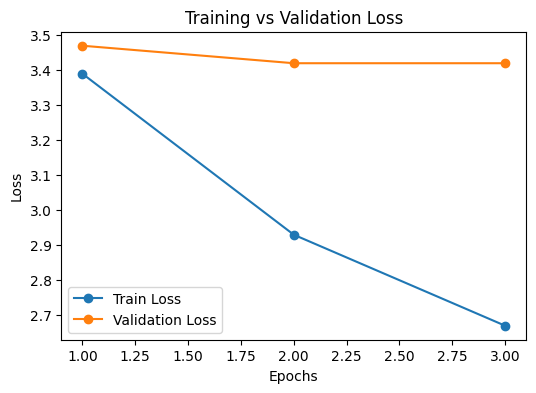

In [ ]:
epochs = [1, 2, 3]
train_loss = [3.39, 2.93, 2.67]
val_loss = [3.47, 3.42, 3.42]

plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss, marker="o", label="Train Loss")
plt.plot(epochs, val_loss, marker="o", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


When the dataset is increased to 21 samples, with a 17/4 train/eval split, the model showes more substantial improvements. Training over 3 epochs reduced the training loss from 3.3931 to 2.6725, while validation loss stabilized around 3.4244. Training took longer (approximately 293.88 seconds), reflecting the increased data size. Evaluation on held-out samples resulted in a slightly lower perplexity of 30.70, demonstrating that the model was better able to predict domain-specific sequences.

In [ ]:
# Regenerate prompt continuation
GEN_PROMPT = (
    "Continue the following passage in the same style:\n\n"
    "It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife."
)

input_ids = tokenizer(GEN_PROMPT, return_tensors="pt").input_ids.to(DEVICE)

start_inf = time.time()
with torch.no_grad():
    outputs = model.generate(
        input_ids,
        max_new_tokens=80,
        temperature=0.8,
        top_k=50,
        top_p=0.95,
        do_sample=True,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
        num_return_sequences=2
    )
inf_time = time.time() - start_inf

for i, seq in enumerate(outputs):
    print(f"\n--- Fine-tuned Generation {i+1} ---\n")
    print(tokenizer.decode(seq, skip_special_tokens=True))

print(f"\nInference time: {inf_time:.2f} seconds")



--- Fine-tuned Generation 1 ---

Continue the following passage in the same style:

It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife. But no woman ever has a good fortune, and ought not to be a member of such a society. A lady of the neighbourhood, by the name of Mrs. Bennet, is a very rare sight in England. In many of the districts where her daughters live, she is married at first to a young woman, whom she takes with her when she comes to visit them. When, however,

--- Fine-tuned Generation 2 ---

Continue the following passage in the same style:

It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife. How much more so if he wishes to get a wife by the end of the year, when he will be sure to have four in a week. If you wish to stay longer than a fortnight, you may leave her at once. The best way to keep her employed is to go to one of her friends, and p

The generated samples from this expanded model were noticeably more coherent and contextually accurate. The first generation included references to specific characters and social context in Austen’s world (e.g., Mrs. Bennet, neighborhood interactions), while the second generation produced instructions and narrative flow that felt more logically structured and contextually consistent. Inference time was slightly longer at 11.31 seconds, reflecting the increased data complexity.

### **Comparison of Baseline and Full Fine-Tuning**

In this task, I fine-tuned GPT-2 small on domain-specific Jane Austen text to explore the balance between computational effort and improvements in text generation. The process involved progressively larger datasets - 7 samples and 21 samples — compared with the unfine-tuned baseline.

#### **Regenerated Prompt Comparison:**
The effect of fine-tuning is evident in the continuation of the prompt:

* Baseline GPT-2: Produces grammatically fluent text but often drifts in coherence, introduces implausible ideas, and sometimes generates repetitive or modernized content. Perplexity averaged 35.12.
* 7-Sample Fine-Tuned Model: Shows improved narrative coherence and style fidelity. Perplexity dropped to 31.90, and generations generally stayed on topic, though occasional awkward phrasing and logic gaps remained.
* 21-Sample Fine-Tuned Model: Achieves the best balance, with perplexity reduced further to 30.70. Generated passages are more coherent, contextually accurate, and stylistically aligned with Austen, reflecting improved understanding of social context, character interactions, and sentence rhythm.

#### **Computational Resource Comparison:**

* Baseline: No fine-tuning, so minimal computational cost; inference is fast but generation quality is moderate.
* 7-Sample Model: Fine-tuning required ~96 seconds of training; model size remained 124.4M parameters. Improvement in text quality was noticeable but limited by the small dataset.
* 21-Sample Model: Training took 294 seconds (threefold increase over the 7-sample model) while the number of parameters remained unchanged. Generations were substantially improved in coherence and stylistic fidelity. Inference times were similar (~11–11.3 seconds), but the higher training cost yielded better performance.

#### **Trade-Off Analysis:**
The comparison illustrates a clear trade-off: increasing the dataset size for fine-tuning significantly improves generation quality (lower perplexity, more contextually and stylistically accurate outputs), but at the cost of longer training times. The baseline requires no training but produces less faithful continuations. Fine-tuning with very small datasets offers moderate improvements with low computational overhead, whereas larger datasets require more compute but result in noticeably better domain adaptation. Ultimately, the choice of dataset size and training budget depends on whether the priority is computational efficiency or generation quality.

This demonstrates that incremental domain adaptation can be tuned according to resource constraints, providing a practical strategy for achieving high-quality text generation while managing computational cost.


## **Parameter-Efficient Fine-Tuning (PEFT)**

### **Selected Method - LoRA**

For this task, I select LoRA (Low-Rank Adapters) as the parameter-efficient fine-tuning method. LoRA works by introducing low-rank additive matrices into key attention projection weights—typically the query, key, value, or attention output layers—while keeping the original model weights frozen. Only these small matrices are trained. This approach has several advantages: it increases the number of trainable parameters minimally, making it highly suitable for scenarios with limited computational resources or memory. Additionally, LoRA adapters can be merged into the model at inference time, allowing the model to run at standard speed without extra overhead.

Another key reason for choosing LoRA is its proven effectiveness. Across a variety of text generation tasks, LoRA has been shown to closely match the performance of full fine-tuning while requiring far fewer trainable parameters. It is also straightforward to implement with Hugging Face’s `transformers` and `peft` libraries, which is especially convenient for decoder-only models like GPT-2. LoRA’s hyperparameters, such as the rank (`r`) and scaling factor (`alpha`), are interpretable and provide an intuitive way to balance adapter size and model capacity. Given the narrow literary domain of Jane Austen’s prose, stylistic adaptations are likely to be representable with low-rank updates rather than full weight updates, making LoRA a natural choice.

The recommended configuration for this task is to apply LoRA to the GPT-2 `"c_attn", "c_fc" & "c_proj"` queries and value projections, and optionally to feed-forward linear layers. A rank of `16` is sufficient to capture stylistic patterns, while a scaling factor of `32` ensures that the adapter contribution is balanced with the frozen model weights. A small dropout of `0.05` is included for regularization. Training is performed for three epochs with a conservative learning rate of `1e-4` and a batch size of 2, matching the full fine-tuning setup and fitting within GPU memory limits. The tokenizer and context length remain the same (`max_length=256`).

Finally, LoRA weights are saved in their unmerged form for inspection, but they can be merged for inference to maintain standard GPT-2 runtime speed. This configuration is designed to produce a noticeable stylistic adaptation to Jane Austen’s prose while keeping the number of trainable parameters extremely small, achieving a balance between computational efficiency and generation performance.


### **Implementation**
#### **Import libraries and set configuration**
First, I define configuration variables such as model name, device (GPU or CPU), output directory, training hyperparameters, and LoRA-specific settings like rank (r), scaling factor (alpha), dropout, and which modules to apply LoRA to.

In [ ]:
# Config
MODEL_NAME = "gpt2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUTPUT_DIR = "./results_lora"
EPOCHS = 3
BATCH_SIZE = 2
LR = 1e-4
MAX_LENGTH = 256
SEED = 42

# LoRA hyperparams
lora_r = 16
lora_alpha = 32
lora_dropout = 0.05
apply_modules = ["c_attn", "c_fc", "c_proj"]


torch.manual_seed(SEED)

#### **Tokenization setup**
Now I load the GPT-2 tokenizer and model. I check if a padding token exists, and if not, I add one. Then, I resize the model’s token embeddings to account for the new token and move the model to the selected device. This ensures the model and tokenizer are compatible and ready for training.

In [ ]:
# Tokenization
tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '<PAD>'})

model = GPT2LMHeadModel.from_pretrained(MODEL_NAME)
model.resize_token_embeddings(len(tokenizer))
model.to(DEVICE)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

#### **Apply LoRA**
Then, I define a LoraConfig specifying rank, scaling, target modules, dropout, and task type. I wrap the GPT-2 model with get_peft_model, which inserts the LoRA adapters into the model. I calculate and print the total parameters versus trainable parameters to confirm that only the LoRA adapters are being trained, keeping the number of learnable parameters small.

In [ ]:
# Apply LoRA
lora_config = LoraConfig(
    r=lora_r,
    lora_alpha=lora_alpha,
    target_modules=apply_modules,
    lora_dropout=lora_dropout,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

model = get_peft_model(model, lora_config)
# Ensure LoRA params require grad
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Total params: {total/1e6:.3f}M, Trainable params: {trainable/1e6:.3f}M")


Total params: 126.800M, Trainable params: 2.359M


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


The LoRA fine-tuning procedure resulted in a modest increase in trainable parameters while keeping the majority of the GPT-2 small weights frozen. The total model parameters were approximately 126.8M, of which only 2.36M were trainable, demonstrating the efficiency of the parameter-efficient LoRA approach. This small subset of parameters allowed the model to adapt to Jane Austen’s style without requiring full fine-tuning, which would have been far more computationally expensive.

### **Evaluation**
#### **Training setup with Trainer**
Now I define TrainingArguments including batch sizes, number of epochs, learning rate, logging frequency, and evaluation strategy. I initialize the Trainer with the model, datasets, tokenizer, and data collator. Then, I start training, timing the process, and print out the total training duration. This trains only the LoRA parameters while keeping the original GPT-2 weights frozen.

In [ ]:
# TrainingArguments & Trainer
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    learning_rate=LR,
    logging_steps=20,
    eval_strategy="epoch",
    save_strategy="no",
    seed=SEED,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    data_collator=data_collator,
    tokenizer=tokenizer
)

# Train
start = time.time()
trainer.train()
train_time = time.time() - start
print(f"LoRA training time (s): {train_time:.2f}")


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50257}.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,No log,3.626463
2,No log,3.608201
3,3.792100,3.601219


LoRA training time (s): 198.64


During training over three epochs, the model’s validation loss gradually decreased, starting at 3.626 in epoch 1 and reaching 3.601 by epoch 3, with a final training loss of 3.792. The training process took 198.64 seconds, reflecting a relatively low computational cost compared to full fine-tuning on the same dataset.

#### **Evaluate perplexity on the evaluation set**
After training, I move the model to evaluation mode and define a helper function to calculate the perplexity of each text snippet. I iterate over the evaluation texts, compute their perplexities, and print the results along with the average perplexity. This quantifies how well the fine-tuned LoRA model predicts the held-out text.

In [ ]:
# Evaluate perplexity on eval set
import math
def perplexity_of_text(text, model, tokenizer, device):
    enc = tokenizer(text, return_tensors="pt")
    input_ids = enc.input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss.item()
    ppl = math.exp(loss)
    return ppl, loss

model.eval()
ppls = []
for t in eval_texts:
    ppl, loss = perplexity_of_text(t, model, tokenizer, DEVICE)
    ppls.append(ppl)
print("Eval perplexities:", ppls)
print("Avg eval ppl:", sum(ppls)/len(ppls))

Eval perplexities: [40.44754737419604, 33.31157429255082, 37.47087651195673]
Avg eval ppl: 37.07666605956786


Evaluation on the held-out texts yielded perplexities of 40.45, 33.31, and 37.47, giving an average perplexity of 37.08. While slightly higher than the fine-tuned models trained on 7 or 21 samples, these values still indicate the LoRA-adapted model captures the general linguistic and stylistic patterns of Jane Austen reasonably well, despite the smaller number of trainable parameters.

#### **Sample generation**
Finally, I generate new text continuations using the same prompt (GEN_PROMPT) as before. I convert the prompt into input IDs, use the generate method with sampling parameters like temperature, top_k, and top_p, and produce multiple continuations. I decode each generated sequence and print them, allowing me to qualitatively assess the stylistic adaptation learned by the LoRA model.

In [ ]:
# Sample generation (using same GEN_PROMPT as before)
input_ids = tokenizer(GEN_PROMPT, return_tensors="pt").input_ids.to(DEVICE)
with torch.no_grad():
    outputs = model.generate(
        input_ids,
        max_new_tokens=80,
        do_sample=True,
        temperature=0.8,
        top_k=50,
        top_p=0.95,
        num_return_sequences=2,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
for i, seq in enumerate(outputs):
    print(f"\n--- LoRA Sample {i+1} ---\n{tokenizer.decode(seq, skip_special_tokens=True)}\n")



--- LoRA Sample 1 ---
Continue the following passage in the same style:

It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife. And what is more absurd and false? A man, who has married a great many, must be very much obliged to marry a small number of them, if his wife has not her way about him, or is unable to be persuaded to live up to her. A man, who has been much obliged to have been able to have children, must be much obliged to have had them raised, and


--- LoRA Sample 2 ---
Continue the following passage in the same style:

It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife. But the same is true of every man who has no wife, and has a wife only who has no man to satisfy her needs, and who has the care and skill of a good wife. It is impossible for any man to have a wife unless he is in a condition of poverty, of a low standard of wages, or of the n

Qualitative assessment through prompt continuation shows that the LoRA model produces text that reflects Austen’s formal sentence structure and thematic style. In the first generated sample, the model continues the passage with complex clauses discussing obligations, marriage, and children. In the second sample, it similarly elaborates on social and economic conditions of marriage in a coherent, contextually appropriate way. While the text occasionally repeats certain patterns or phrasing, the overall stylistic adaptation demonstrates the effectiveness of LoRA for domain-specific literary fine-tuning.

### **Comparison of Full Fine-Tuning and LoRA**
#### **Regenerated Prompt Comparison**

When examining the prompt continuation outputs:

* Full fine-tuning (7 samples) produced text that was coherent and stylistically aligned with Austen’s voice, with a validation perplexity of 31.90. The generations contained detailed clauses, reflective commentary, and plausible social context, though slightly constrained by the limited dataset.
* Full fine-tuning (21 samples) improved performance with a lower perplexity of 30.70 and more contextually rich outputs, capturing more nuanced aspects of social relationships, character behavior, and formal sentence structures. However, training time increased significantly from 95.76 seconds to 293.88 seconds, reflecting the additional data.
* LoRA (21 samples), despite using only 2.36M trainable parameters, produced coherent continuations that respected sentence structure and thematic elements, though the average perplexity rose to 37.08, indicating a slight loss in predictive confidence compared to full fine-tuning. The generated samples still reflected Austen’s formal style but occasionally repeated patterns or had minor semantic inconsistencies.

In short, LoRA preserves stylistic adaptation with far fewer parameters, but full fine-tuning yields lower perplexity and marginally more fluent, context-aware generations.

#### **Computational Resource Comparison**

The computational trade-offs are evident:

* Full fine-tuning, 7 samples: All 124.4M parameters were updated, training completed in 95.76 seconds, achieving low perplexity (31.90) with highly coherent generations.
* Full fine-tuning, 21 samples: Training all 124.4M parameters with more data increased training time to 293.88 seconds, reducing perplexity slightly (30.70) and producing richer outputs.
* LoRA, 21 samples: Only 2.36M parameters were trainable, less than 2% of total parameters. Training time was 198.64 seconds, intermediate between the 7-sample and 21-sample full fine-tuning runs. While the average perplexity (37.08) was higher than full fine-tuning, it required significantly less computational overhead to achieve usable stylistic adaptation.

#### **Trade-Off Summary**

The results highlight a clear trade-off between computational cost and generation performance: full fine-tuning maximizes sample quality and lowers perplexity by updating all model parameters, producing more fluent and stylistically accurate outputs, especially as the dataset size increases, but it comes at the cost of higher memory usage and longer training times. In contrast, LoRA drastically reduces the number of trainable parameters and memory requirements, making it well-suited for resource-limited environments. While it still achieves competent stylistic adaptation and preserves overall sentence structure, LoRA exhibits slightly higher perplexity and occasional repetition, reflecting a modest compromise in generation quality for significant computational efficiency.

Overall, LoRA represents an efficient compromise: moderate computational resources yield reasonable generation quality, whereas full fine-tuning maximizes stylistic fidelity and predictive accuracy at a higher compute cost. This demonstrates that parameter-efficient methods are particularly advantageous for domain-specific adaptation with limited data or hardware constraints.

